In [1]:
import pandas as pd
from shapely.geometry import Point, Polygon
import numpy as np
from time import time
import os


In [2]:
import os
import pandas as pd

folder = '../AIS_data'
files = os.listdir(folder)

min_data_points = 100

all_df = pd.DataFrame()
for file in files:
    if file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(folder, file))
        df = df[df['LAT'].apply(lambda x: len(x) >= min_data_points)]  # filter short elapsed rows
        all_df = pd.concat([all_df, df], ignore_index=True)


In [3]:
all_df.head()

,MMSI,elapsed_s,LAT,LON,VesselType,Label
0,367659930,"[0, 69, 138, 210, 279, 349, 420, 488, 570, 639...","[30.4289, 30.42774, 30.42675, 30.42573, 30.424...","[-87.99302, -87.99258, -87.9919, -87.99129, -8...",31.0,0
1,367553360,"[0, 70, 149, 220, 301, 379, 449, 559, 630, 709...","[29.01648, 29.01666, 29.01664, 29.01661, 29.01...","[-91.83069, -91.83175, -91.83304, -91.83416, -...",30.0,0
2,367461560,"[0, 64, 134, 204, 274, 354, 425, 495, 45847, 4...","[29.36644, 29.36952, 29.37291, 29.3762, 29.379...","[-91.38801, -91.38525, -91.38225, -91.37948, -...",90.0,0
3,538007067,"[0, 120, 301, 483, 662, 843, 1023, 1204, 1383,...","[28.82299, 28.82325, 28.8236, 28.82388, 28.824...","[-89.33299, -89.33357, -89.3343, -89.33491, -8...",70.0,0
4,369053000,"[0, 70, 139, 209, 270, 340, 410, 473, 540, 610...","[30.18058, 30.17847, 30.17641, 30.17425, 30.17...","[-88.56405, -88.56745, -88.57083, -88.57432, -...",90.0,0


In [4]:
all_df.drop(columns=['MMSI', 'VesselType'], inplace=True)


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



# Feature extraction function
def extract_features(row):
    elapsed = np.array(row['elapsed_s'])
    lat = np.array(row['LAT'])
    lon = np.array(row['LON'])

    
    
    # Calculate duration
    duration = elapsed[-1] - elapsed[0]
    
    # Calculate simple speed approximations
    dlat = np.diff(lat)
    dlon = np.diff(lon)
    dt = np.diff(elapsed) + 1e-6  # prevent division by zero
    speeds = np.sqrt(dlat**2 + dlon**2) / dt
    
    return pd.Series({
        # 'duration': duration,
        'lat_mean': lat.mean(),
        'lat_std': lat.std(),
        'lon_mean': lon.mean(),
        'lon_std': lon.std(),
        'speed_mean': speeds.mean(),
        'speed_std': speeds.std(),
        # 'seq_len': len(elapsed)
    })

# Apply feature extraction
features = all_df.apply(extract_features, axis=1)

# Prepare train/test sets
X = features
y = all_df['Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58853
           1       0.89      0.44      0.59       505

    accuracy                           0.99     59358
   macro avg       0.94      0.72      0.79     59358
weighted avg       0.99      0.99      0.99     59358



In [10]:
X

,lat_mean,lat_std,lon_mean,lon_std,speed_mean,speed_std
0,30.324618,0.047122,-87.903259,0.068003,1.520286e-05,9.880400e-06
1,28.953475,0.077996,-91.502626,0.224377,1.008802e-05,1.387394e-05
2,29.213490,0.079397,-91.404074,0.028022,1.387749e-05,3.094376e-05
3,28.822487,0.001178,-89.333770,0.001293,4.915938e-07,5.158963e-07
4,30.171884,0.011064,-88.744727,0.131171,2.642389e-05,3.479417e-05
...,...,...,...,...,...,...
296782,28.646663,0.170977,-89.308369,0.104131,3.982501e-05,4.308371e-05
296783,28.624968,0.181957,-89.325142,0.079961,4.241511e-05,3.870482e-05
296784,28.865848,0.107478,-90.096276,0.116995,3.948535e-05,2.984727e-05
296785,30.303276,0.195597,-88.062989,0.060417,5.285400e-05,3.847035e-05


In [7]:
importances = clf.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

      Feature  Importance
2    lon_mean    0.217555
0    lat_mean    0.192177
5   speed_std    0.168353
4  speed_mean    0.146348
3     lon_std    0.139172
1     lat_std    0.136395


/tmp/ipykernel_709962/357208998.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


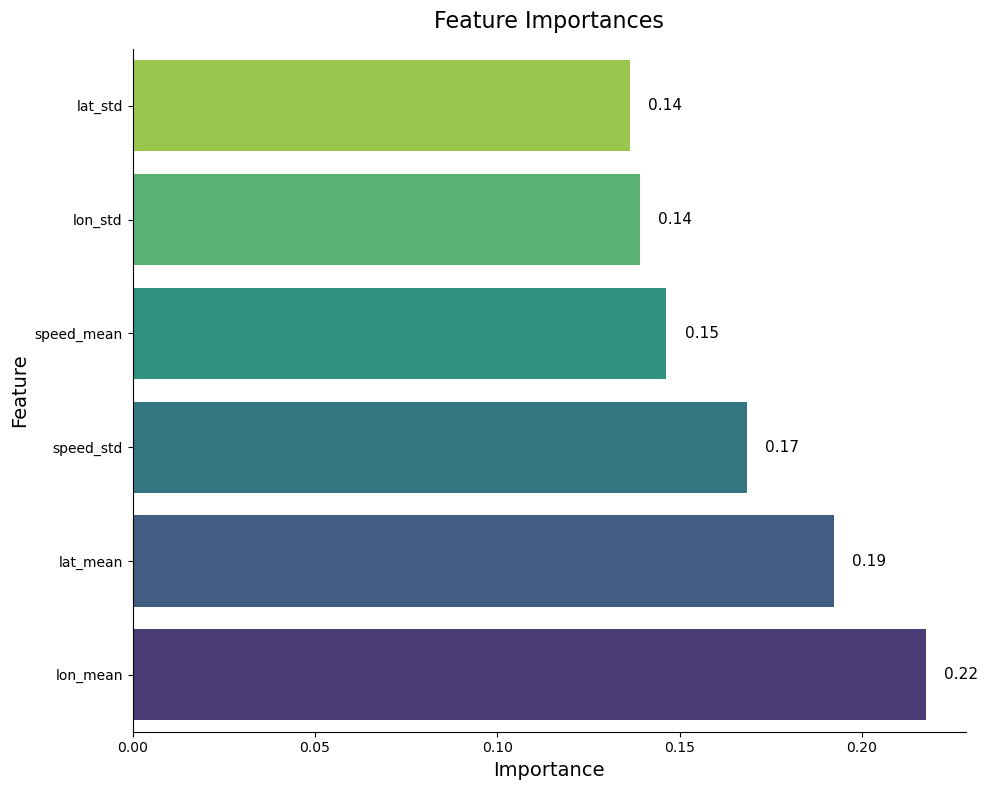

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt



# Create the bar plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df,
    palette="viridis"
)

# Invert y-axis so the most important features are at the top
ax.invert_yaxis()

# Add data labels on each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.005, p.get_y() + p.get_height() / 2,
            f"{width:.2f}", va='center', fontsize=11)

# Titles and labels
ax.set_title("Feature Importances", fontsize=16, pad=15)
ax.set_xlabel("Importance", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
sns.despine()

plt.tight_layout()
plt.savefig("feature_importances.pdf", format='pdf')
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# 1) Custom Dataset that returns (seq_tensor, length, label)
class TripDataset(Dataset):
    def __init__(self, df):
        self.seqs, self.lengths, self.labels = [], [], []
        for _, row in df.iterrows():
            # stack into shape [seq_len, 3]
            arr = np.stack([row['elapsed_s'], row['LAT'], row['LON']], axis=1)
            tensor = torch.tensor(arr, dtype=torch.float32)
            self.seqs.append(tensor)
            self.lengths.append(tensor.size(0))
            self.labels.append(int(row['Label']))
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.seqs[idx], self.lengths[idx], self.labels[idx]

# 2) Collate fn to pad a batch
def collate_fn(batch):
    seqs, lengths, labels = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long)
    labels  = torch.tensor(labels,  dtype=torch.long)
    # pad to [batch, max_len, 3]
    padded = pad_sequence(seqs, batch_first=True)
    return padded, lengths, labels

# 3) Split your DataFrame
train_df, test_df = train_test_split(
    all_df, stratify=all_df['Label'], 
    test_size=0.2, random_state=42
)

train_ds = TripDataset(train_df)
test_ds  = TripDataset(test_df)

train_loader = DataLoader(
    train_ds, batch_size=264, shuffle=True, 
    collate_fn=collate_fn
)
test_loader  = DataLoader(
    test_ds, batch_size=64, shuffle=False, 
    collate_fn=collate_fn
)

# 4) Define LSTM‐based classifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, num_classes)
    def forward(self, x, lengths):
        # pack + run LSTM
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        # take last layer's hidden state: shape (batch, hidden_size)
        out = h_n[-1]
        return self.fc(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = LSTMClassifier().to(device)
# 0) Compute class weights on the training labels
classes       = np.unique(train_df['Label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['Label'].to_numpy()
)
# make a tensor in the same order as `classes`
weights_tensor = torch.tensor(
    [class_weights[np.where(classes == c)[0][0]] for c in range(len(classes))],
    dtype=torch.float32,
    device=device
)

# 1) Define weighted loss
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5) Training loop
model.train()
for epoch in range(1, 21):
    total_loss = 0
    for seqs, lengths, labels in train_loader:
        seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seqs, lengths)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * seqs.size(0)
    print(f"Epoch {epoch:02d} — loss: {total_loss/len(train_ds):.4f}")




KeyboardInterrupt: 

In [ ]:
# 6) Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for seqs, lengths, labels in test_loader:
        seqs, lengths = seqs.to(device), lengths.to(device)
        logits = model(seqs, lengths)
        preds  = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nTest Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))